<a href="https://colab.research.google.com/github/Anand7Choudhary/audioIt/blob/main/audioIt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AudioIt

##Introduction
Text summarization is a method that presents a condensed version of one or more texts with semantics (Gupta & Lehal, 2010), while audio summarization offers audiences the convenience of listening to an audio summary rather than reading a text summary (Vartakavi et al., 2021). In this project, we focus on audio-to-audio summarization using mp3 audio as inputs to summarize the content into shorter versions while not losing much emotion information. Our primary objective is to identify the best-performing model for audio-to-audio summarization among the models we have explored. This technique will potentially enhance businesses efficiency and broaden accessibility, benefiting diverse audiences such as individuals with visual impairments, thereby making it applicable for daily use across various scenarios.

##Data Preparation
The data input for this project consists of three audio mp3 files extracted from different sources. Each audio provides a different context and emotions, as can be seen in table below.

The selection of audio is based on the appropriate duration, which is three to four minutes, so that the model can perform with the input. We also consider the representation of different emotions, offering various sentiments to be analyzed in the project. After the audio is inputted, for the first part of the project, we convert mp3 audio to WAV audio for further analysis.

## Install Necessary Packages

In [ ]:
# Install Whisper for audio transcription.
!pip install git+https://github.com/openai/whisper.git
# Install SpeechRecognition for converting speech to text.
!pip install speechrecognition
# Install Hugging Face's transformers for NLP tasks.
!pip install transformers
# Install gTTS for Google's text-to-speech services.
!pip install gTTS
# Install tqdm for progress bars.
!pip install tqdm
# Install pydub for audio manipulation.
!pip install pydub
# Install IPython for an interactive computing environment.
!pip install ipython
# Install espeak for speech synthesis.
!apt-get install espeak
# Install pocketsphinx for lightweight speech recognition.
!pip install pocketsphinx
# Install torch with transformers for deep learning models.
!pip install transformers[torch]

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-9mte_clu
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-9mte_clu
  Resolved https://github.com/openai/whisper.git to commit ba3f3cd54b0e5b8ce1ab3de13e32122d0d5f98ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
espeak is already the newest version (1.48.15+dfsg-3).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


## Import the necessary Libraries

In [ ]:
import os  # Interface with the operating system.
import time  # Access time-related functions.
import torch  # Framework for machine learning and deep learning.
import whisper  # OpenAI's model for audio transcription.
import transformers  # Hugging Face's library for NLP tasks.
import pocketsphinx  # Lightweight speech recognition engine.
import speech_recognition as sr  # Library to convert speech into text.
from tqdm import tqdm  # Visual progress bars in loops.
from gtts import gTTS  # Google's text-to-speech API.
from google.colab import files  # Handle file uploads and downloads in Colab.
from pydub import AudioSegment  # Manipulate audio with a high-level interface.
from IPython.display import Audio  # Display audio widgets in Jupyter notebooks.
from transformers import pipeline, Trainer, TrainingArguments, BartTokenizer, AutoTokenizer  # Components for NLP modeling and data processing.

In [ ]:
def convert_to_wav(source_file):
    audio = AudioSegment.from_file(source_file)
    output_file = source_file.rsplit('.', 1)[0] + '.wav'
    audio.export(output_file, format='wav')
    return output_file

##Audio-to-Audio Summarization


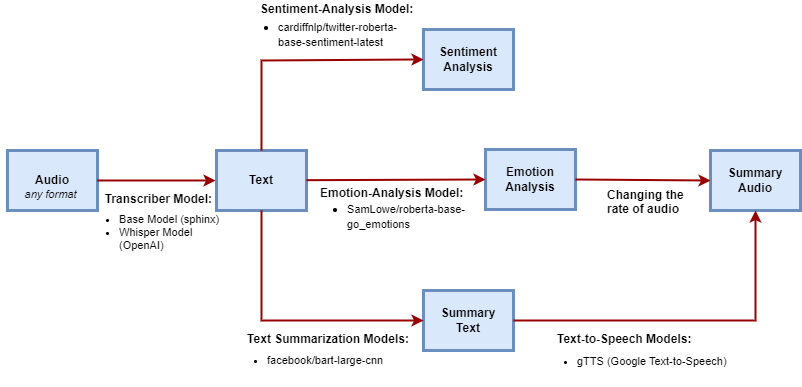

###Audio-to-Text Transcript
Converting audio to text is the crucial first step in our audio summarization process. In this stage, we aim to transcribe spoken content into written text from recorded audio with high accuracy, considering factors such as accents, speaking speed, and background noise. We applied two methods for audio-to-text, the first utilizing CMU Sphinx, which is a more basic model, and the second using OpenAI Whisper, a state-of-the-art deep-learning model.

In [ ]:
def transcribe_audio_sphinx(file_path):
    """ Transcribe audio using Sphinx through SpeechRecognition. """
    text = "Model was not able to read the audio"  # Default text if transcription fails
    r = sr.Recognizer()  # Create a recognizer instance
    with sr.AudioFile(file_path) as source:
        audio = r.record(source)  # Read the entire audio file
    try:
        text = r.recognize_sphinx(audio)  # Attempt to transcribe audio using Sphinx
        return text
    except sr.UnknownValueError:
        print("Sphinx could not understand audio")  # Error if audio is unintelligible
        return text
    except sr.RequestError as e:
        print(f"Sphinx error; {e}")  # Handle other errors from Sphinx
        return text
    return text

In [ ]:
def transcribe_audio_whisper(audio_path):
    """ Transcribe audio using OpenAI's Whisper model. """
    model = whisper.load_model("small")  # Load the small Whisper model
    result = model.transcribe(audio_path)  # Perform transcription of the audio file
    return result["text"]  # Return the transcribed text

###Sentiment Analysis for Transcript
We employed two pre-trained models from HuggingFace to analyze text sentiment:
1. Sentiment Analysis:

  We used the ```cardiffnlp/twitter-roberta-base-sentiment-latest``` model to identify the overall sentiment (positive, negative, or neutral) expressed in a piece of text.
2. Emotion Detection:
  
  We then employed the ```SamLowe/roberta-base-go_emotions``` model to uncover the specific emotions (e.g., joy, anger, sadness) present within the text.

In [ ]:
# Initialize tokenizer and sentiment analysis tools from Hugging Face's transformers
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
sentiment_analyzer = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

# Reinitialize tokenizer for a different model focused on emotions
tokenizer = AutoTokenizer.from_pretrained("SamLowe/roberta-base-go_emotions")
emotion_analyzer = pipeline("text-classification", model="SamLowe/roberta-base-go_emotions")

def sentiment_chunk_text(text, max_length):
    """ Split text into manageable chunks for sentiment analysis. """
    token_ids = tokenizer.encode(text, add_special_tokens=True)  # Tokenize text including special tokens
    num_chunks = len(token_ids) // max_length + (1 if len(token_ids) % max_length != 0 else 0)
    chunks = [tokenizer.decode(token_ids[i * max_length: min((i + 1) * max_length, len(token_ids))]) for i in range(num_chunks)]
    return chunks

def aggregate_sentiments(results):
    """ Aggregate sentiment scores from multiple chunks. """
    sentiment_scores = {}
    for result in results:
        label = result[0]['label']
        score = result[0]['score']
        if label in sentiment_scores:
            sentiment_scores[label].append(score)
        else:
            sentiment_scores[label] = [score]
    most_frequent_sentiment = max(sentiment_scores, key=lambda x: len(sentiment_scores[x]))
    average_score = sum(sentiment_scores[most_frequent_sentiment]) / len(sentiment_scores[most_frequent_sentiment])
    return most_frequent_sentiment, average_score

def emotion_chunk_text(text, max_length):
    """ Split text into chunks that fit emotion analysis model's token limit. """
    tokens = tokenizer.tokenize(text)
    num_chunks = len(tokens) // max_length + (1 if len(tokens) % max_length else 0)
    chunks = [tokenizer.convert_tokens_to_string(tokens[i * max_length:(i + 1) * max_length]) for i in range(num_chunks)]
    return chunks

def aggregate_emotions(results):
    """ Aggregate emotion detection results. """
    emotion_counts = {}
    for result in results:
        for res in result:
            label = res['label']
            score = res['score']
            if label in emotion_counts:
                emotion_counts[label].append(score)
            else:
                emotion_counts[label] = [score]
    most_frequent_emotion = max(emotion_counts, key=lambda x: len(emotion_counts[x]))
    average_score = sum(emotion_counts[most_frequent_emotion]) / len(emotion_counts[most_frequent_emotion])
    return most_frequent_emotion, average_score

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def analyze_sentiment_and_emotion(transcript):
    """ Analyze sentiment and emotion from a given transcript. """
    if transcript:
        # Divide the transcript into chunks for sentiment analysis
        chunks = sentiment_chunk_text(transcript, 500)  # Use 500 tokens limit to accommodate special tokens
        results = []
        for chunk in chunks:
            result = sentiment_analyzer(chunk)  # Perform sentiment analysis on each chunk
            results.append(result)
        print("Stage (2/5) : Sentiment Analysis")
        final_sentiment, sentiment_score = aggregate_sentiments(results)  # Aggregate results to get overall sentiment
        print(".\n.\n----- Sentiment Analysis Completed -----")

        # Repeat the process for emotion analysis
        chunks = emotion_chunk_text(transcript, 500)
        results = [emotion_analyzer(chunk) for chunk in chunks]  # Perform emotion analysis on each chunk
        print("Stage (3/5) : Emotion Analysis")
        final_emotion, emotion_score = aggregate_emotions(results)  # Aggregate results to get overall emotion
        print(".\n.\n----- Emotion Analysis Completed -----")
    else:
        print("We have faced an Error")
        final_sentiment = "No transcript available"
        sentiment_score = 0
        final_emotion = "No transcript available"
        emotion_score = 0
    return final_sentiment, sentiment_score, final_emotion, emotion_score

###Text Summarization
The objective of this step is to extract the principal idea of the audio from its transcription by utilising the ```bart-large-cnn``` model, which is capable of handling up to 1024 tokens simultaneously. This methodology facilitates the generation of a summary of a substantial text corpus in a time-efficient manner, by eliminating redundant information and reducing the time required for audience comprehension.

The result of text summary is highly dependent on the minimum and maximum length settings of the model. The smaller the maximum length, the less information is conveyed in the summary. Consequently, in order to comply with the maximum length limit of the model and create a concise and informative summary, the entire input text was divided into multiple chunks. The text is then subjected to summarization by the summarizer, with the summaries of each chunk being joined to form a full summary of the whole input.

Additionally, there are other transformer models that can be employed for text summarization. However, the ```bart-large-cnn``` model has been observed to produce summaries with fewer spelling and grammar mistakes than  ```google-t5-base``` and ```pegasus```, making it a more reliable choice for generating high-quality summaries.

In [ ]:
# Set up the tokenizer and summarizer using BART from Facebook's model collection
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
summarizer = pipeline('summarization', model='facebook/bart-large-cnn')

def summary_chunk_text(text, max_length):
    """ Splits the text into chunks that fit the token limit of the summarizer. """
    token_ids = tokenizer.encode(text, add_special_tokens=True)  # Tokenize the text including special tokens
    max_length -= 2  # Adjust for special tokens at the start and end
    num_chunks = len(token_ids) // max_length + (1 if len(token_ids) % max_length != 0 else 0)
    chunks = [
        tokenizer.decode(token_ids[i * max_length: min((i + 1) * max_length, len(token_ids))])
        for i in range(num_chunks)  # Decode each chunk back into text
    ]
    return chunks

def summarize_text(text, chunk_max_length, min_length, max_length):
    """ Summarizes the text using the summarizer model, handling token limits per chunk. """
    chunks = summary_chunk_text(text, chunk_max_length)  # Split text into manageable chunks
    if chunks:  # Ensure there are chunks before dividing
        max_length_per_chunk = max_length // len(chunks)  # Calculate max length for each chunk based on the number of chunks
    else:
        max_length_per_chunk = max_length  # If no chunks, the max length remains unchanged
    min_length_per_chunk=max_length_per_chunk
    summarized_text = []
    for chunk in chunks:
        summary = summarizer(chunk, min_length=min_length_per_chunk, max_length=max_length_per_chunk, truncation=True)  # Summarize each chunk
        summarized_text.append(summary[0]['summary_text'])  # Collect the summaries
    return " ".join(summarized_text)  # Combine all summaries into one text

In [ ]:
# t="""Hello and welcome back to episode two of the Eli5M podcast. You will remember last week we talked about what is machine learning, what it means to learn, and what the difference between a machine learning algorithm and a statistics algorithm is, and that fundamentally it's about our goal of learning something from one set of data and being able to apply it to a new set of data. So this week we're going to carry on that theme and I'm going to start by talking about a joke. Now this was a joke that was a cartoon I read a long time ago on the internet somewhere and then lost and couldn't find and misremembered. Eventually later in life I did find the original one but it wasn't as good as the way I remembered it. So I'm going to tell you my misremembering of a joke I found on the internet about a decade ago. So in my version of it there's this big party and we've got all of the sciences at this party. We've got biology and exercise science, they're dancing away on the dance floor. We've got chemistry doing something illegal in the toilets. Sociology is outside trying to persuade the bouncer to let them in, but obviously they're not a real science and they're not allowed in. You've got ethnography with a back against the wall, they're just watching everyone. And then here is the star of our show. Over in the corner of the room we've got physics and physics is wearing this mask over her face. Psychology notices this. Psychology is really interested in people. She's really interested in why people do things. So she strolls over to physics and asks her, what's underneath your mask? And then with a big reveal she pulls it off and underneath the mask it says maths and everyone screams and runs away. So that's the joke. The reason it's a joke is that everyone thinks physics is cool, but actually physics is mostly just maths and everyone hates and is scared of maths. The same thing is true of machine learning. When we take off machine learning's mask we get trouble. Optimisation. Cue the theme song. Okay, so we've just revealed, we've just done the reveal on machine learning. We've seen that under the mask machine learning is actually optimisation. And I think reflecting on my conversations with students, everyone thinks they want to learn about machine learning. Machine learning is the cool kid about town. It's got the nice trainers. It's got the witty things. It wears the sunglasses, right? Optimisation seems old and boring, not the fashionable thing. You all want to learn about machine learning. None of you want to learn about optimisation. But optimisation is the thing that makes machine learning a thing. Without optimisation we would not have machine learning. It is the bit that gets everything done. In machine learning, and this is the title of this week's podcast, Why are you wig? We would, we could say. Why are you wig? It's not the most catchier phrases. I'm borrowing directly from computer science where you may hear the phrase, whizzy wig. Y, W, Y, S, W, Y, G. What you say is what you get. Whatever we tell the computer we want in terms of programming, that's what we get on the other side. So in machine learning, the phrase is, what you optimise is what you get. Whatever we decide our optimisation process is, that is essentially what our machine learns, building on last week. And you may well hear terms around this in this space, often written in confusing ways about cost functions and loss functions. In fact, all these are some measure, the objective function of our optimization algorithm, typically just measuring how long our algorithm is. So we train our algorithm on some data. It will make mistakes. The mistakes it makes are judged according to a loss function. We talked about this last week. Our role is to build an environment to learn within. And essentially what we're building here is a set of learning objectives. Ultimately, most machine learning is trying to minimise this loss function to train our model. If we can minimise the number of mistakes, whatever that is, our model makes, our model is learning something it can apply to new data. We can go on to our assessment with a slightly different problem and judge how clever our model is. So just a couple of notes on terminology. So the loss function versus the cost function, in fact, they are the same thing. Loss function, a loss occurs at a data item level or at a batch level. So as we train one run of our training process through the data, we would have some loss associated with that. When we've done all of our training, we call it cost. So loss is on an individual basis. Cost is across the whole thing. Often you see the terms used interchangeably because they basically describe the same thing. The mathematical function is the same. Loss applies to part of the data. Cost applies to all of it. One other note, our friends in reinforcement learning, that's not really my area, so I won't talk about it as much, but our friends in reinforcement learning work in a slightly different way. They're slightly more positive people. They're nicer people. They don't really measure how wrong things are. They measure how well things do. So if you were building a driverless car, you would have a function that measures how well the car obeys the traffic rules, stays on the road, doesn't kill people. And we would call that a reward function. So in most machine learning, it's loss and cost. How wrong are you? In reinforcement learning, it's reward. How right are you? So that's my setup. Let's go all the way back to last week, and I gave you this metaphor of us as data scientists or as analysts working with machine learning. And what we're trying to do is not solve problems as such, but create the right learning environment for computers, for machines to solve the problems themselves. Okay, that is our job is the building of that environment. The optimization, the thing we optimize for in our world of learning environments is essentially the learning outcomes of our module. As a module developer as a teacher, I'm asked to write out for any module that I create a set of learning outcomes. And these days, they're very, very strict about it and make sure whatever I status the learning outcomes is exactly what I should deliver in the classroom. You guys get to see the learning outcomes. If I'm not meeting those learning outcomes, you have every right to complain. Those learning outcomes should dictate what I put in my slides, what I teach you, how I set up that environment. The learning outcomes are not only the training, though, they're also the assessment. So again, someone will check this, they will check that when I design an assessment, when I design an exam paper, does it actually assess the learning outcomes I have set? And if it doesn't, it's deemed to be a problem that is too different from your training. And if it does, we have an appropriate assessment. So absolutely, why are you weak? Whatever we decide our learning outcomes are in our module, that's how we teach it. That's how we assess it. Whatever we decide our optimization is, whatever we decide our objective function is, whatever we optimize for is exactly what we get in terms of a machine learning model. If we set a poor loss function, much like if I get set a bad set of learning outcomes, we're going to have poor classes, we're going to have a poor exam paper, you're going to be very angry students, you're going to hate me even more than you do now, which I imagine is quite a lot. And ultimately, I will be failing to help you to learn. And I'm failing to assess whether you have actually learned on the other side. This is even more true when we talk about machine learning, because compared to students, algorithms are ruthlessly single-minded. They have no interest in academic discussion. They have no interest in self-improvement. And an algorithm, an ML algorithm, is that annoying person at the back of the classroom when you start talking about something, puts their hand up and says, is this going to be in the exam? And if you answer no, they just go back to sleep. That's exactly how machine learning works. It only cares about passing the module and getting the best possible market. It has no interest in anything other than that. It's completely driven towards that goal. So if we want our model to think in a particular way, that is how we have to write our objective function. That is what we need to optimize against. So just to make this a bit real, let's go to a couple of scenarios. And I'm going to talk about an AI marking tool. Some of you have heard me talking about this before, and you hate me for talking about it again, but that's okay. So we're going to create this AI marking tool. It's going to take in essays or exam papers and mark them in an automated fashion. And first things first, I'm going to design a rubbish one. And it's going to be rubbish because it's objective function will be rubbish. The simplest objective function I may come up with, all I'm going to do is provide a set of words that I think relate to this topic, topic X. And I'm going to count how many times they occur in your exam paper. I'm going to maximize the number of times those words occur, subject to some overall word count. So now all I'm doing is rewarding you for writing related words to the topic. If you've written lots of words about that, it must be a great exam. What that will also reward them. In fact, what that will reward you best for is just randomly writing this list of words with no consideration for sentences, no consideration for meaning, no consideration towards answering the question. It just becomes an objective function that rewards you writing out some stream of consciousness unrelated words that are just key to this topic area. So we can see if that's our objective function, my AI marking tool is rubbish. What we actually need is something much, much more complicated than that. We need a function that rewards probably the use of these words, but also rewards the writing of whole sentences, rewards coherency, rewards a connection between the answer you write and the question that has been set. We need something complicated. In many ways, the complexity of this system is just the complexity of the objective function that we write. Okay, so you all tell me you hate the AI marking tool idea. I really love it because I hate marking just done some marking last night. So I am keen to have this tool more than ever and make my life a bit easier, but to accompany that one will give you a real example. There's a piece of software some of you may have heard of it's a little bit obscure. It may be something that's influential in the future. It's called chat GPT. You probably have heard of it thinking about it. Chat GPT gives us a perfect illustration of why I wig and why we need to think about optimization if we want to be good at machine learning. So chat GPT the original model chat GPT. Well, let's just give you the acronym GPT. So GPT stands for generative pre trained transformer. So generative because it generates text transformer because it's based on the transformer architecture will be talking about later in this podcast and also on your modules. Let's focus on the P the P stands for pre trained. The chat GPT is based on a pre trained model. That means it was originally trained on something else a different problem. And it was originally trained with a different data set to the way chat GPT. The GPT was pre trained on the GPT model was on a very, very large Internet corpus. So huge amount of documents from the Internet and the particular challenge roughly speaking, it was asked to do its objective function. It would hide, take a sentence, hide one of the words and try to predict what the missing word was. So the loss function was how accurately it will predict that missing word and it will go through these hundreds of millions of documents, hiding all of these words, trying to predict the word that is missing. When a model becomes quite good at doing that, it gets quite good at knowing what word should occur where in each sentence. So when we come to making that into a chat bot into a chat GPT, the first versions, the early versions take that prior learning. That prior objective function and apply a new objective function. So what they were trying to do in this case was generate a new word each time. So it generates responses to you based on your initial prompt. It generates one word and then considering the prompt, considering the word it said previously, it greedily tries to produce the next word. Now, if you play around with these these kind of decoders, the coders that have been set up in this way that have been trained just to be probabilistic. And there's a famous critique of these tools that they are stochastic parents. They just produce the most probable word. A fair critique in many ways. What they do each time is just look again just looking at the previous words they've written, looking at the prompt. What is the most probable word to write next? We call that a greedy type approach has been greedy is just going for the one that gives it the most probability. Often these tools can get stuck in a loop where they keep saying the same thing over and over again. So the man went shopping in the shops to go shopping in the shops to go shopping in the shops. That's not an exaggeration. The early generation tools trained in this greedy fashion often produced outputs like that that kept repeating themselves. Not high quality text. So what the guys and girls at open AI decided to do was take that pre trained GPT model and then fine tune it in a different way with a different objective function. They call this reinforced learning with human preferences are LHP. So the idea was they would take two versions of the same article. I think extracted from Reddit as well. And they would ask a human to rank which one they liked best or they would ask lots of humans to rank which ones like best. They liked best. And from that you can derive a function that says these are the factors that humans are looking for in a response. Now we have an objective function of reward function in this case that is based on writing something a human will prefer. The model was then fine tuned retrained with that objective function. So rather than just being greedy trying to produce the most probable word instead it's trying to produce a set of words that a human would like to read. We retrain it in that way and suddenly we have the chat GPT that we know and love that can write wonderful prose, cheat exams, all of that good stuff. So hopefully you can see as much as you guys think optimization is not for me. It's not cool. It's not the fashionable thing. Optimization is absolutely the glue that makes machine learning work and it's something we should all care about the creativity of machine learning is in designing these clever complete objective functions. So hopefully I've solved that to you. I will look forward to seeing you again next week."""
# # Calculate parameters for summarization
# input_length = len(tokenizer.encode(t))  # Encode the transcript to determine its length
# summary_length = max(50, int(input_length / 6))  # Determine the summary length based on input length
# final_summary = summarize_text(t, 1000, min_length=summary_length, max_length=summary_length)
# print(final_summary)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Last week we talked about what is machine learning, and what it means to learn. This week we're going to carry on that theme and I'm going to talk about a joke. The joke is that everyone thinks physics is cool, but actually physics is mostly just maths and everyone hates and is scared of maths. The same thing is true of machine learning. When we take off machine learning's mask we get trouble. Optimisation is the thing that makes machine learning a thing. Without optimisation we would not have machinelearning. It is the bit that gets everything done. And this is the title of this week's podcast, Why are you In machine learning, loss and cost are the same. In reinforcement learning, it's reward. If we set a poor loss function, much like if I get set a bad set of learning outcomes, we're going to have poor classes. And ultimately, I will be failing to help you to learn. And I'm failing to assess whether you have actually learned on the other side. So that's my setup. Let's go all the way

In [ ]:
# # Convert the summarized text to speech with and without emotional tones
# t="""Last week we talked about what is machine learning, and what it means to learn. This week we're going to carry on that theme and I'm going to talk about a joke. The joke is that everyone thinks physics is cool, but actually physics is mostly just maths and everyone hates and is scared of maths. The same thing is true of machine learning. When we take off machine learning's mask we get trouble. Optimisation is the thing that makes machine learning a thing. Without optimisation we would not have machinelearning. It is the bit that gets everything done. And this is the title of this week's podcast, Why are you In machine learning, loss and cost are the same. In reinforcement learning, it's reward. If we set a poor loss function, much like if I get set a bad set of learning outcomes, we're going to have poor classes. And ultimately, I will be failing to help you to learn. And I'm failing to assess whether you have actually learned on the other side. So that's my setup. Let's go all the way back to last week, and I gave you this metaphor of us as data scientists or as analysts working with machine learning. And what we're trying to do is not solve problems as such, but create Chat GPT is based on a pre trained model. That means it was originally trained on something else a different problem. So it generates responses to you based on your initial prompt. It generates one word and then considering the prompt, considering the word it said previously, it greedily tries to produce the next word. We need a function that rewards probably the use of these words, but also rewards the writing of whole sentences, rewards coherency, rewards a connection between the answer you write and the question that has been set. The complexity of this system is just the complexity of the objective function that we write. We call that a greedy type The model was then fine tuned retrained with that objective function. Now we have an objective function of reward function in this case that is based on writing something a human will prefer. We retrain it in that way and suddenly we have the chat GPT that we know and love that can write wonderful prose, cheat exams, all of that good stuff. So hopefully you can see as much as you guys think optimization is not for me, it's not cool. It's not the fashionable thing. Optimization is absolutely the glue that makes machine learning work and it's something we should all care about the creativity of machine learning is in designing these"""
# audio_output1, audio_output2 = text_to_speech_gtts(t, "neutral", "Advance")
# print("----- Text to Audio Completed -----")
# print("Audio with Emotions : ")
# display(audio_output1)
# print("Audio without Emotions : ")
# display(audio_output2)

Adjusting audio: 168it [00:00, 1683.10it/s]


----- Text to Audio Completed -----
Audio with Emotions : 


Audio without Emotions : 


###Text-to-Speech Audio
In this stage, our goal is to convert the summarized text into audio again. This step essentially allows more extensive application and accessibility of the summary for a larger audience. We employed Google Text-to-Speech (gTTS) to generate MP3 audio files containing the spoken version of the input text, which is the summarized text. While more advanced text-to-speech options exist, gTTS excels in its simplicity and affordability, making it a great choice for quick and convenient audio generation.

We tried gTTS with and without adjustments in parameters such as speaking rate, loudness, and pitch shift according to different emotion labels identified in the earlier stages, aiming at preserving the emotion information in the original audio file via this modification.

In [ ]:
def text_to_speech_gtts(text, emotion,method):
    rate = 1.0  # Default speech rate
    loudness = 0  # Default loudness (dB)
    pitch_shift = 0  # Default pitch shift (semi-tones)

        # Emotional impact on audio properties
    if emotion in ['sadness', 'grief']:
        rate = 0.9  # Very slow for sadness and grief
        loudness = -2  # Very quiet for sadness and grief
        pitch_shift = 0  # Lower pitch for sadness and grief
    elif emotion == 'disappointment':
        rate = 0.85  # Slower for disappointment
        loudness = -2  # Quieter for disappointment
        pitch_shift = 0  # Lower pitch for disappointment
    elif emotion in ['anger', 'annoyance']:
        rate = 1.15  # Faster for anger and annoyance
        loudness = 3  # Louder for anger and annoyance
        pitch_shift = 1  # Higher pitch for anger and annoyance
    elif emotion == 'disgust':
        rate = 1.0  # Normal rate for disgust
        loudness = -1  # Slightly quieter for disgust
        pitch_shift = 1  # Lower pitch for disgust
    elif emotion in ['joy', 'amusement', 'gratitude']:
        rate = 1.1  # Slightly faster for positive emotions
        loudness = 2  # Slightly louder for positive emotions
        pitch_shift = 1  # Slightly higher pitch for positive emotions
    elif emotion == 'love':
        rate = 0.8  # Slower for love
        loudness = 1  # Slightly louder for love
        pitch_shift = 0  # No pitch shift for love
    elif emotion == 'excitement':
        rate = 1.2  # Faster for excitement
        loudness = 4  # Louder for excitement
        pitch_shift = 1  # Higher pitch for excitement
    elif emotion in ['fear', 'nervousness']:
        rate = 1.1  # Slightly faster for fear and nervousness
        loudness = -1  # Slightly quieter for fear and nervousness
        pitch_shift = 0  # Higher pitch for fear and nervousness
    elif emotion in ['surprise', 'realization']:
        rate = 1.2  # Faster for surprise and realization
        loudness = 2  # Slightly louder for surprise and realization
        pitch_shift = 2  # Higher pitch for surprise and realization
    elif emotion in ['curiosity', 'confusion']:
        rate = 1.05  # Slower for curiosity and confusion
        loudness = -1  # Slightly quieter for curiosity and confusion
        pitch_shift = -1  # Lower pitch for curiosity and confusion
    elif emotion in ['relief', 'remorse', 'approval', 'pride', 'admiration']:
        rate = 1.05  # Normal rate for complex emotions
        loudness = 1  # Slightly louder for complex emotions
        pitch_shift = 1  # Slightly higher pitch for complex emotions

    # Generate speech using gTTS
    tts = gTTS(text=text, lang='en', tld='com')
    base_filename = f"{method}_base.mp3"
    tts.save(base_filename)

    # Load the base audio file
    base_audio = AudioSegment.from_file(base_filename)

    # Create the "without emotions" audio
    without_emotions_filename = f"{method}_without_emotions.mp3"
    base_audio.export(without_emotions_filename, format="mp3")

    adjusted_audio = AudioSegment.empty()
    for chunk in tqdm(base_audio[::1000], desc="Adjusting audio"):
        adjusted_chunk = chunk._spawn(chunk.raw_data, overrides={
            "frame_rate": int(chunk.frame_rate * rate),
            "loudness": loudness,
            "pitch_shift": pitch_shift
        })

        adjusted_audio += adjusted_chunk

    # Save the "with emotions" audio
    with_emotions_filename = f"{method}_with_emotions.mp3"
    adjusted_audio.export(with_emotions_filename, format="mp3")

    # Clean up temporary file
    os.remove(base_filename)

    # Return the audio for playback
    return Audio(with_emotions_filename, autoplay=False),Audio(without_emotions_filename, autoplay=False)

In [ ]:
def process_audio_file(file_path, method):
    """Process an audio file using a specified transcription method and analyze sentiment and emotion."""
    print('Stage (1/5) : Transcript Generation')
    # Select the transcription method based on the provided 'method' argument
    if method == 'whisper':
        transcript = transcribe_audio_whisper(file_path)  # Use Whisper for transcription if selected
    else:
        transcript = transcribe_audio_sphinx(file_path)  # Use Sphinx by default
    print('.\n.\n----- Transcript Generation Completed -----')

    # Analyze the sentiment and emotion from the transcript
    sentiment, sentiment_score, emotion, emotion_score = analyze_sentiment_and_emotion(transcript)
    print('Stage (4/5) : Audio Summarization Initiated')
    print("With current GPU(T4) Resource the average execution time is 15-20min")

    # Calculate parameters for summarization
    input_length = len(tokenizer.encode(transcript))  # Encode the transcript to determine its length
    summary_length = max(50, int(input_length / 6))  # Determine the summary length based on input length

    # Summarize the transcript
    final_summary = summarize_text(transcript, 1000, min_length=summary_length, max_length=summary_length)
    print('.\n.\n----- Summarization Completed ------')
    # Return all the results
    return transcript, sentiment, sentiment_score, emotion, emotion_score, final_summary

###Model Evaluation

####Basic Model Evaluation

In [ ]:
def runBasicModel(filePath):
    """Executes a basic audio processing model using Sphinx for transcription."""
    # Process the audio file using the Sphinx method
    transcript_sphinx, sentiment_sphinx, sentiment_sphinx_score, emotion_sphinx, emotion_sphinx_score, summarizedText = process_audio_file(filePath, method='sphinx')
    print("Using Sphinx:")
    print("Transcript:", transcript_sphinx)
    # Output the results of sentiment and emotion analysis
    print(f"Sentiment: {sentiment_sphinx}, Score: {sentiment_sphinx_score:.2f}")
    print(f"Emotion: {emotion_sphinx}, Score: {emotion_sphinx_score:.2f}")
    print("Summarized Text:", summarizedText)
    print("Stage (5/5) : Processing Text to Audio")

    # Convert the summarized text to speech with and without emotional tones
    audio_output1, audio_output2 = text_to_speech_gtts(summarizedText, emotion_sphinx, "Basic")
    print("----- Text to Audio Completed -----")
    print("Audio with Emotions : ")
    display(audio_output1)
    print("Audio without Emotions : ")
    display(audio_output2)

# Code for handling file uploads in a Jupyter environment
uploaded = files.upload()
file_path_sphinx = list(uploaded.keys())[0]

# Check and convert the file to WAV format if necessary
if not file_path_sphinx.endswith('.wav'):
    file_path_sphinx1 = convert_to_wav(file_path_sphinx)

# Process the audio file using the basic model
runBasicModel(file_path_sphinx1)

Saving Love2.mp3 to Love2.mp3
Stage (1/5) : Transcript Generation
.
.
----- Transcript Generation Completed -----
Stage (2/5) : Sentiment Analysis
.
.
----- Sentiment Analysis Completed -----
Stage (3/5) : Emotion Analysis
.
.
----- Emotion Analysis Completed -----
Stage (4/5) : Audio Summarization Initiated
With current GPU(T4) Resource the average execution time is 15-20min
.
.
----- Summarization Completed ------
Using Sphinx:
Transcript: the girl for justin on don't you listen to tear hormones as review of reviews of beauty and he knew that you know when sitting observe the for the tour my cousin who do you recall bulldozers music video uses the g. is illegal idea that will lose it get your stuff and we spent the veil of ward valley ventura do as you're about to felicity youth to find no end it to you and you did you do and you found it was a sound is dead and found you wouldn't have it handy at the land now a hot dogs found a dead down here and that they have done him wrong go ahe

Adjusting audio: 23it [00:00, 2931.65it/s]


----- Text to Audio Completed -----
Audio with Emotions : 


Audio without Emotions : 


As can be seen in the above output, the basic model with Sphinx being the transcriber failed to transcribe the audio content correctly; many words were wrongly recognized. Also, there existed no punctuation mark at all in the output, which looked like a huge long sentence. The transcriber cannot identify the fact that the audio is a conversation between two people, which is an important piece of information that lost in the transcript.

For sentiment analysis, since it was based on a poorly transcribed output, the anger emotion in the input audio could not be captured successfully (with sentiment being recognized as positive and emotion neutral). The summary was incomplete due to the maximum length settings of the model. Also, the summarized output largely repeated the first few sentences, perhaps because the messy transcript did not make sence semantically.

Since the sentiment and emotion were not identified correctly and the transcription and and summary were poorly performanced, the final text-to-speech output yielded no difference for parameter adjustments. gTTS correctly read the input summary, yet the output was still not realistic enough due limitations such as voice (speaker) selection, which again lost the conversation nature of the original audio.

####Advanced Model Evaluation

In [ ]:
def runAdvanceModels(filePath):
    """Executes an advanced audio processing model using OpenAI's Whisper for transcription."""
    # Process the audio file using the Whisper method for more accurate and advanced transcription
    transcript_whisper, sentiment_whisper, sentiment_whisper_score, emotion_whisper, emotion_whisper_score, summarizedText = process_audio_file(filePath, method='whisper')
    print("Using Whisper:")
    print("Transcript:", transcript_whisper)
    # Display the results of sentiment and emotion analysis
    print(f"Sentiment: {sentiment_whisper}, Score: {sentiment_whisper_score:.2f}")
    print(f"Emotion: {emotion_whisper}, Score: {emotion_whisper_score:.2f}")
    print("Summarized Text:", summarizedText)
    print("Stage (5/5) : Processing Text to Audio")

    # Convert the summarized text to speech with and without emotional tones
    audio_output1, audio_output2 = text_to_speech_gtts(summarizedText, emotion_whisper, "Advance")
    print("----- Text to Audio Completed -----")
    print("Audio with Emotions : ")
    display(audio_output1)
    print("Audio without Emotions : ")
    display(audio_output2)

# Code for handling file uploads in a Jupyter environment
uploaded = files.upload()
file_path_whisper = list(uploaded.keys())[0]

# Process the audio file using the advanced model
runAdvanceModels(file_path_whisper)

Saving Micheal-mortenson-eli5m-episode-2-wyoiwyg.mp3 to Micheal-mortenson-eli5m-episode-2-wyoiwyg.mp3
Stage (1/5) : Transcript Generation


/usr/local/lib/python3.10/dist-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


.
.
----- Transcript Generation Completed -----
Stage (2/5) : Sentiment Analysis
.
.
----- Sentiment Analysis Completed -----
Stage (3/5) : Emotion Analysis
.
.
----- Emotion Analysis Completed -----
Stage (4/5) : Audio Summarization Initiated
With current GPU(T4) Resource the average execution time is 15-20min
.
.
----- Summarization Completed ------
Using Whisper:
Transcript:  Hello and welcome back to episode two of the Eli5M podcast. You will remember last week we talked about what is machine learning, what it means to learn, and what the difference between a machine learning algorithm and a statistics algorithm is, and that fundamentally it's about our goal of learning something from one set of data and being able to apply it to a new set of data. So this week we're going to carry on that theme and I'm going to start by talking about a joke. Now this was a joke that was a cartoon I read a long time ago on the internet somewhere and then lost and couldn't find and misremembered. Ev

Adjusting audio: 173it [00:00, 1283.65it/s]


----- Text to Audio Completed -----
Audio with Emotions : 


Audio without Emotions : 


With the use of OpenAI Whisper as our transcriber, the content of the input audio, even for some parts with two people speak simultaneously, was correctly, perfectly recognized with appropriate punctuation marks separating sentences. Sentiment and emotion were successfully identified as negative and anger, with a score of 0.76 and 0.36 respectively. The conversation nature of the audio was not retained in the transcription.

The summarized text seemed to try capturing the core messages in each chunk instead of simply repeating sentences in the same order as the transcript; proper punctuation marks were used as well in the summary. Again, the summary was incomplete due to the maximum length settings of the model.

For text-to-speech audio, it can be found that the audio output with emotions, compared to the one without emotions, was of higher speaking rate, volume, and pitch, reflecting the adjustment we made to simulate anger in speeches. However, the limitations mentioned above still existed. More advanced text-to-speech models might be considered if greater control and more natural-sounding voices are needed.


##Limitations and Recommendations
While we acknowledge that the end-to-end process of the audio-to-audio project shares the desired output, some limitations still exist. Following is the breakdown of the limitations/challenges for this project.
  
* Pre-trained models may struggle with out-of-vocabulary words or rare words that were not present in the training data.

* Pre-trained models are trained on vast amounts of text data from the internet; therefore, they may contain biases or skewed representations of certain topics.  These biases can propagate through the model's predictions and affect downstream applications.

* The model processing limit of 512 tokens necessitated splitting longer texts into smaller chunks for analysis.

* Google Collab provides limited GPU processing power to develop a training model. Therefore, for this project, pre-trained models were incorporated to avoid any significant computational burden.  

* Emotion Analysis is restricted to a limited predefined set of emotions defined by the GoEmotions dataset, which restricts the performance based on the input text.

For optimal performance, balance model complexity with computational resources. Fine-tune sentiment and emotion models for domain-specific understanding. Enhance summarization models for fluency. Ensure seamless integration of audio-to-text and text-to-audio methods. Continuously evaluate and adapt the pipeline for improved user experience and efficiency.

##Conclusion

##References
* A. Vartakavi, A. Garg and Z. Rafii, "Audio Summarization for Podcasts," 2021 29th European Signal Processing Conference (EUSIPCO), Dublin, Ireland, 2021, pp. 431-435, doi: 10.23919/EUSIPCO54536.2021.9615948.  


* Vishal Gupta, Gurpreet Singh Lehal. A survey of Text summarization techniques , Journal of Emerging Technologies in Web Intelligence VOL 2 NO 3 ;August 2010.